# Assignment 2

## Problem Statement Explanation:

For this assignment, we have to download the data from [here](http://jmcauley.ucsd.edu/data/amazon/links.html), any reviews file that has at least a million reviews.<br>
I've chosen to use the "Books" review dataset that contains 8,898,041 reviews.

Assigned tasks once the download is done:

- Find the item with the least rating
- Find the item with the most rating
- Find the item with the longest reviews
- Store it into a parquet file
- Ingest the data in a postgre table

> **To download the dataset, please execute the below cell.<br>Please note that it will download to the current directory you are in and unzip it.**

Library Versions used: [requirements.txt](requirements.txt)

In [1]:
# !wget "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz"
# !gunzip reviews_Books_5.json.gz

Before running the below cell it is recommended to run the below command in the terminal to create an environment (Linux):

```
python3 -m venv .env
source .env/bin/activate
pip install -r requirements.txt
```
<br>

Importing Libraries that will be used to answer the above questions. <br>

> Using a try-except catch here to make sure if there is an exception *"ModuleNotFoundError"* it will run the `requirements.txt` file on the active environment 

In [2]:
try:
    import pyspark
    from pyspark.sql import SparkSession
    from pyspark.sql import functions as F
    import logging, datetime
except ModuleNotFoundError:
    !pip install -r requirements.txt

Setting up an logger to customize a few logs that are basic checks.

> Setting up the logger level at "INFO" meaning almost any event will be reported to the log file.<br>
> `format` keyword is used to format the logs to a necessary required format

In [3]:
capture_log_time = datetime.datetime.now()
log_file_path = f"./books_{capture_log_time.date()}_at_runtime_{capture_log_time.hour}:{capture_log_time.minute}.log"
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s - %(message)s')

logging.info(f"INITIALIZING books script")

## Creation of Class

Creating a class `Transformation`. This is to assist us make the code modular and maintainable. I've tried to follow the SOLID principles of Python coding and added docstrings for better understanding. 

> Due to the various kind of exceptions that can be thrown for a path related method, using a generalized way of catching exception

In [4]:
class Transformation:
    """
    Provides methods for common data transformation tasks using a SparkSession.
    Args:
        spark (SparkSession): The SparkSession to use for transformations.
    """

    def __init__(self, spark):
        self.spark = spark
        logging.info(f"== Spark session started ==")

    def exit_spark(self):
        logging.info(f"== Spark session stopped ==")
        self.spark.stop()

    def json_reader(self, path:str):
        """
        Reads a JSON file into a Spark DataFrame.
        Args:
            path (str): The path to the JSON file.
        Returns:
            DataFrame: The DataFrame containing the JSON data.
        Raises:
            Exception: If an error occurs during reading.
        """
        try:
            return self.spark.read.json(path)
        except Exception as e:
            logging.critical(f"ERROR: {e} with {path}")

    def parquet_writer(self, df, path:str):
        """
        Writes a Spark DataFrame to a Parquet file.
        Args:
            df (DataFrame): The DataFrame to write.
            path (str): The path to the output Parquet file.
        Raises:
            Exception: If an error occurs during writing.
        """
        try:
            return df.repartition(1).write.mode('overwrite').parquet(path)
        except Exception as e:
            logging.critical(f"ERROR: {e} with {path}")
            
    def transform_time(self, df, col_name:str, format_out:str, format_in=None, unix=False):
        """
        Transforms a time-related column in a DataFrame.
        Args:
            df: The DataFrame containing the column to transform.
            col_name: The name of the column to transform.
            format_out: The desired output format for the transformed column.
            format_in (optional): The input format of the column, if not Unix timestamp. Defaults to None.
            unix (optional): Whether the column is in Unix timestamp format. Defaults to False.
        Returns:
            DataFrame: The DataFrame with the transformed column.
        """
        logging.info(f"Transforming {col_name} to format {format_out} and isUnix is {unix}")
        if not unix and format_in != None:
            return df.withColumn(col_name , F.date_format(F.to_date(F.col(col_name), format_in), format_out))
        elif unix:
            return df.withColumn(col_name, F.date_format(F.from_unixtime(col_name), format_out))
        else:
            raise Exception("For unix=False, format_in is necessary")

- `spark.executor.memory`: Used for data processing and computations.
- `spark.driver.memory`: Used for managing jobs
- `spark.executor.cores`: Used for parallel processing
- `spark.executor.instances`: Used for better processing capacity
- `spark.sql.legacy.timeParserPolicy`: Used for datetime related bugs to not arise
- `spark.jars`: Used for Read/Write operation to any external database

You can download the `.jar` file from [here.](https://jdbc.postgresql.org/download/) 
<br>The file path is passed as the value in `spark.jars`

> If you want console logs to be printed uncomment line `spark.sparkContext.setLogLevel("INFO")`.<br>
> **Note:** It makes the jupyter notebook lengthy as it's set on `INFO` level.

In [5]:
spark = SparkSession.builder \
    .appName("amz_reviews") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "5") \
    .config("spark.executor.instances", "5") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.jars", "./bin/postgresql-42.7.1.jar") \
    .getOrCreate()

spark.sparkContext.setLogLevel("FATAL") # Use FATAL for cleaner notebook

23/12/25 20:46:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
processor = Transformation(spark)

In [7]:
review_df = processor.json_reader("./raw_lake/reviews_Books_5.json")

In [8]:
review_df = processor.transform_time(review_df, 'reviewTime', format_in='MM dd, yyyy', format_out='MM-dd-yyyy')
review_df = processor.transform_time(review_df, 'unixReviewTime', format_out='MM-dd-yyyy', unix=True)

In [9]:
review_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)



## Description of the columns

`asin` - ID of the product, e.g. 0000013714<br>
`helpful` - helpfulness rating of the review, e.g. 2/3<br>
`overall` - rating of the product<br>
`reviewText` - text of the review<br>
`reviewTime` - time of the review (raw)<br>
`reviewerID` - ID of the reviewer, e.g. A2SUAM1J3GNN3B<br>
`reviewerName` - name of the reviewer<br>
`summary` - summary of the review<br>
`unixReviewTime` - time of the review (unix time)

## Least and Most reviews

To find the least or the most reviews we need to *group by* `asin` as it's the ID of the product (unique value)
<br>Then *count* the number of reviews for each `asin`
<br>Then *sort* them in ascending for least reviews and descending for most reviews.

In [10]:
least_reviews = review_df.groupBy("asin").count().sort(F.asc("count"))

In [11]:
most_reviews = review_df.groupBy("asin").count().sort(F.desc("count"))

## Longest reviews:

To find the longest review we choose the `reviewText` column and get the *length* of each given text.
<br>Then, we *group by* `asin` 
<br>Perform two aggregration using the *sum* total of the *length*
<br>And finally, *sorting* it in desending order of the length.

In [12]:
review_df = review_df.withColumn('length_summary', F.length(F.col('reviewText')))
longest_reviews = review_df.groupby("asin").agg(F.sum("length_summary").alias("total_len")).sort(F.desc("total_len"))                                    

In the above cell we are intentionally not showing the output as spark engine by default prefers to behave with lazy loading enabled. This is what allows spark to enhance performance over large datasets.<br> While keeping the lazy loading active to get the result out we run 3 computation queries using the `first()` method. 

Once computed -  we create a new dataframe and store the values along with the ASIN ids for a better view of the data.

In [13]:
logging.info(f"Executing data computation: {datetime.datetime.now()}")
results = least_reviews.first(), most_reviews.first(), longest_reviews.first()
logging.info(f"Computation end time: {datetime.datetime.now()}")


final_answers = spark.createDataFrame([
    ("asin", results[0][0], results[1][0], results[2][0]),
    ("values", results[0][1], results[1][1], results[2][1])
], "ref string, least_review_asin string, most_review_asin string, longest_reviews_asin string")

final_answers.show()

+------+-----------------+----------------+--------------------+
|   ref|least_review_asin|most_review_asin|longest_reviews_asin|
+------+-----------------+----------------+--------------------+
|  asin|       0023605103|      030758836X|          0439023483|
|values|                5|            7440|             4763508|
+------+-----------------+----------------+--------------------+



In [14]:
review_df = review_df.withColumn("total_votes", F.col("helpful")[1])
review_df = review_df.withColumn("actual_helpful", F.col("helpful")[0])
review_df = review_df.drop("helpful")

Encoding the `reviewText` as there are unknown charecters that the respective datatype can not intake.

In [15]:
review_df = review_df.withColumn("reviewText", F.encode(F.col("reviewText"), "UTF-8"))

# Saving the dataframe to postgre Table

Before running the below cell, it is **important** to run postgre DB. 
To run the postgre we are using docker here:

If you don't have docker installed, install docker by running:

```
sudo snap install docker
```

Once docker is installed, execute the below command to run postgres:

```
docker run -it \
	-e POSTGRES_USER="root" \
	-e POSTGRES_PASSWORD="root" \
	-e POSTGRES_DB="books" \
	-v $(pwd)/books_review_data:/var/lib/postgresql/data \
	-p 5432:5432 \
	postgres:13
```

Now you can run the below cell to insert data into the postgre table.

> Note to update your username and password accordingly

In [16]:
username = "root"
password = "root"

logging.info(f"Inserting data into Postgre: {datetime.datetime.now()}")
review_df.write.jdbc(url="jdbc:postgresql://localhost:5432/books",
                     table="reviews_data",
                     mode="overwrite", 
                     properties={
                         "user": username,
                         "password": password,
                         "driver": "org.postgresql.Driver"
                     })
logging.info(f"Insertion complete: {datetime.datetime.now()}")

I've additionally installed `pgcli` to query the postgreDB. Images attached below:

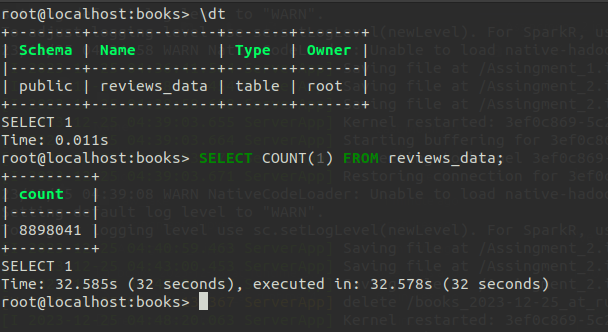

> We can see that the count on the DB matches with the total mentioned in the website.

In [17]:
review_df = review_df.withColumn("reviewText", F.decode(F.col("reviewText"), "UTF-8"))
review_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)
 |-- length_summary: integer (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- actual_helpful: long (nullable = true)



The below row of code will save the transformed dataframe into a `.parquet` file. 

Original File Size: `9.5 GB`<br>
Parquest File Size: `4.9 GB`

Even with the introduction of new columns the space the data consumes is almost a half less than the original dump. 

In [18]:
logging.info(f"Writing to parquet: {datetime.datetime.now()}")
processor.parquet_writer(review_df, "./raw_lake/books_parquet")
logging.info(f"Writing complete: {datetime.datetime.now()}")

In [19]:
review_df.unpersist()
processor.exit_spark()

# Final Results:

1. Item with the least ratings:
   > **ASIN: 0029184657** with `5` ratings.
3. Item with the most ratings:
   > **ASIN: 030758836X** with `7440` ratings.
5. Item with the longest reviews:
   > **ASIN: 0439023483** with accumulative lenght of reviews `4763508` letters.